# Разработка модели классификации на фродовые заказы


Ключевые этапы:
* Изучить предоставленные данные и провести первичный анализ (EDA).
* Разработать и обучить модель классификации (учитывая сильный дисбаланс классов 1:10).
* Оценить качество модели с фокусом на метрики для миноритарного класса.
* Реализовать прототип сервиса (django/FastAPI/Flask/Streamlit/Gradio или др.):
  * Принимает табличные данные,
  * Возвращает предсказанную метку и вероятность.
* Подготовить отчёт, описав подход, ключевые результаты и инструкцию по запуску.


## Структура данных

Датасет представлен в табличном формате и содержит следующие колонки:

`user_id` - идентификатор пользователя

`created_date` - дата создания записи

`nm_id` - идентификатор товара

`total_ordered` - общее количество заказанных товаров

`payment_type` - тип оплаты

`is_paid` - флаг оплаты (булево значение)

`count_items` - количество товаров за последнее время

`unique_items` - количество уникальных товаров за последнее время

`avg_unique_purchase` - среднее количество уникальных покупок за последнее время

`is_courier` - флаг доставки курьером

`nm_age` - возраст товара

`Distance` - расстояние

`days_after_registration` - дни после регистрации

`number_of_orders` - количество заказов

`number_of_ordered_items` - количество заказанных товаров

`mean_number_of_ordered_items` - среднее количество заказанных товаров

`min_number_of_ordered_items` - минимальное количество заказанных товаров

`max_number_of_ordered_items` - максимальное количество заказанных товаров

`mean_percent_of_ordered_items` - средний процент заказанных товаров

`target` - целевая переменная (0 - не требуется блокировка, 1 - требуется блокировка)

`service` - тип региона

Датасет имеет сильный дисбаланс классов в соотношении 1:10 (класс 1 встречается значительно реже).


## Требования к задаче

**Анализ данных (EDA):**
* Исследовать распределение признаков
* Проанализировать дисбаланс (сколько объектов каждого класса)
* Выявить корреляции между признаками
* Проверить наличие пропущенных значений и выбросов

**Предобработка данных:**
* Обработка пропущенных значений
* Кодирование категориальных признаков
* Масштабирование числовых признаков
* Работа с дисбалансом классов (SMOTE, undersampling, class weights и т.д.)

**Построение модели:**
* Любой фреймворк (scikit-learn, XGBoost, LightGBM, CatBoost и т.д.)
* Можно использовать ансамблевые методы
* Учитывать баланс между качеством и скоростью

**Оценка качества:**
* Основные метрики для миноритарного класса: Precision и Recall
* Дополнительные метрики: F1-score, PR-AUC, ROC-AUC
* Обязательная оценка Confusion Matrix

**Подготовка результатов:**
* Валидация: подбираем гиперпараметры
* Тест: итоговая метрика

**Развёртывание сервиса:**
* REST API (Flask/FastAPI) либо UI (Streamlit/Gradio)
* /predict эндпоинт, возвращающий {"prediction": 0 или 1, "confidence": float}

**Отчёт:**
* Описание подхода, модели, метрик
* Результаты на тесте


## Методика оценки

**Оценка качества модели для миноритарного (целевого) класса:**
* Неудовлетворительный результат:
  * Recall < 0.1 при Precision < 0.75
* Хороший результат:
  * 0.1 ≤ Recall при 0.8 ≤ Precision 
* Победитель:
  * Recall ≥ 0.1 при максимальном Precision

**Дополнительные метрики:**
* F1-score — комбинированная метрика Precision и Recall (используется для сравнения моделей)
* PR-AUC — особенно важна для несбалансированных данных
* ROC-AUC — оценка разделительной способности модели


### Рассмотрим распределение признаков

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data_train = pd.read_csv('./data/df_train.csv')

display(data_train.head())

,user_id,nm_id,CreatedDate,service,total_ordered,PaymentType,IsPaid,count_items,unique_items,avg_unique_purchase,...,NmAge,Distance,DaysAfterRegistration,number_of_orders,number_of_ordered_items,mean_number_of_ordered_items,min_number_of_ordered_items,max_number_of_ordered_items,mean_percent_of_ordered_items,target
0,1,1,2025-01-05 02:20:24+03:00,nnsz,627,CSH,False,4,4,1.00,...,117,3443,73,1,627,627.0,627,627,100.000000,0
1,2,2,2024-11-05 09:05:21+03:00,nnsz,512,CRD,True,0,0,0.00,...,920,3478,1237,2,606,303.0,94,512,50.000000,0
2,3,3,2024-12-11 13:45:33+03:00,nnsz,500,CRD,True,0,0,0.00,...,420,771,4003,1,500,500.0,500,500,100.000000,0
3,4,4,2025-01-24 07:47:34+03:00,nnsz,452,CSH,False,6,2,0.33,...,20112,763,977,5,1102,220.4,100,452,20.000000,0
4,5,5,2024-11-27 11:50:43+03:00,nnsz,450,CRD,True,0,0,0.00,...,141,1089,1637,3,549,183.0,1,450,33.333333,0


In [323]:
display(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105565 entries, 0 to 105564
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   user_id                        105565 non-null  int64  
 1   nm_id                          105565 non-null  int64  
 2   CreatedDate                    105565 non-null  object 
 3   service                        105565 non-null  object 
 4   total_ordered                  105565 non-null  int64  
 5   PaymentType                    105565 non-null  object 
 6   IsPaid                         105565 non-null  bool   
 7   count_items                    105565 non-null  int64  
 8   unique_items                   105565 non-null  int64  
 9   avg_unique_purchase            105565 non-null  float64
 10  is_courier                     105565 non-null  int64  
 11  NmAge                          105565 non-null  int64  
 12  Distance                      

None

Пропусков нет, все типы данных соответствуют записям в этих колонках, можно перевести данные о времени в datetime и переименовать часть колонок в snake case

In [2]:
# Обернем в функцию чтобы после применить на тестовом датасете
def base_preprocess(df):

    columns = list(df.columns)

    # Последовательное переименование каждого столбца в snake case
    for i, column in enumerate(columns):
        columns[i] = ''.join(['_' + i.lower() if i.isupper() else i for i in column]).lstrip('_')

    df.columns = columns

    # Преобразование столбца со временем в datetime
    df['created_date'] = pd.to_datetime(df['created_date'])

    df['day'] = df['created_date'].dt.day
    df['hour'] = df['created_date'].dt.hour
    df['weekday'] = df['created_date'].dt.weekday

    return df

In [3]:
# Вызываем функцию для тренировочного датасета
data_train = base_preprocess(data_train)

In [4]:
display(data_train['target'].value_counts())

target
0    92211
1    13354
Name: count, dtype: int64

Наблюдается дисбаланс классов в target, что нужно будет учесть при обучени моделей

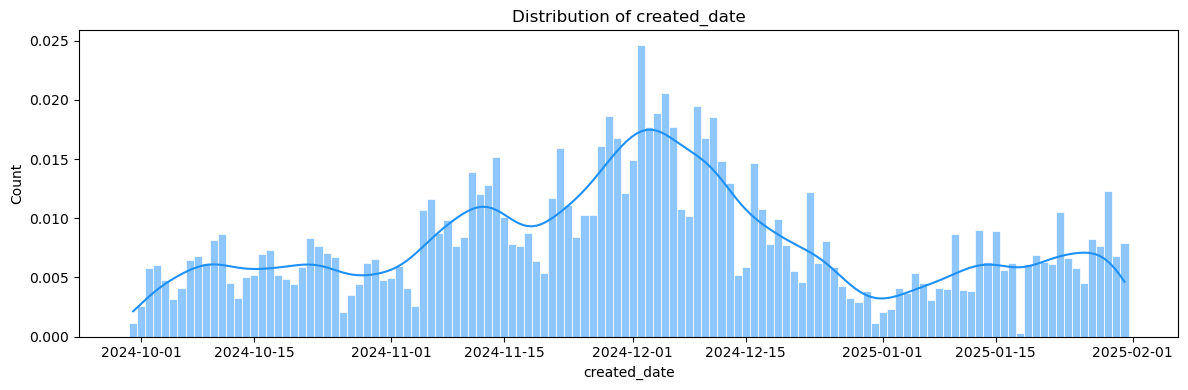

C:\Users\chudp\AppData\Local\Temp\ipykernel_24260\583982557.py:19: UserWarning: 
The palette list has fewer values (3) than needed (31) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=data_train[col], palette=['beige','dodgerblue', 'red'],


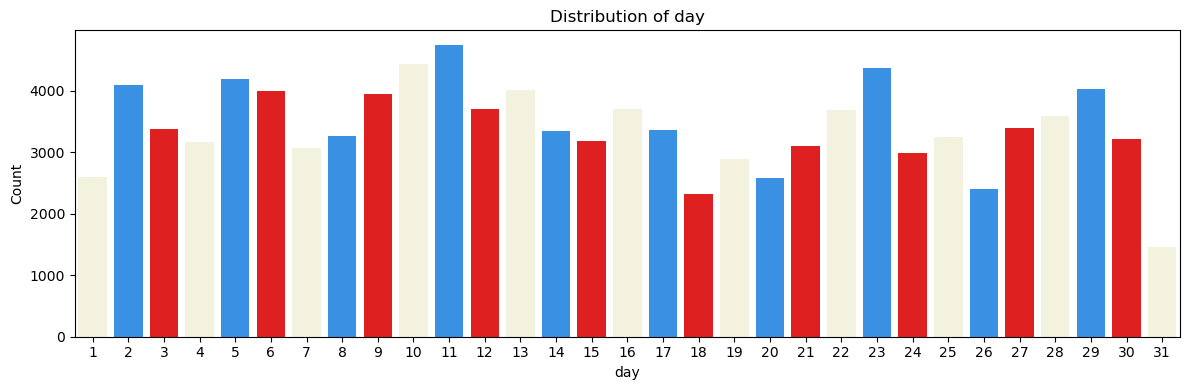

C:\Users\chudp\AppData\Local\Temp\ipykernel_24260\583982557.py:19: UserWarning: 
The palette list has fewer values (3) than needed (24) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=data_train[col], palette=['beige','dodgerblue', 'red'],


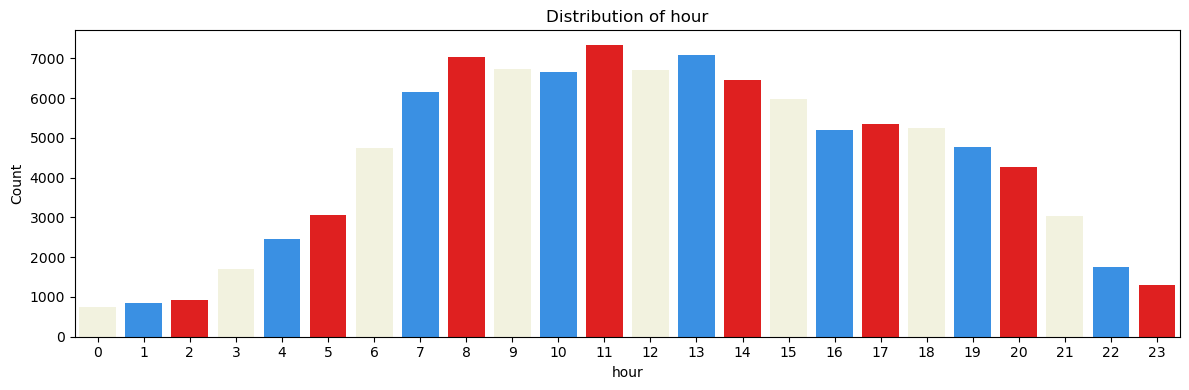

C:\Users\chudp\AppData\Local\Temp\ipykernel_24260\583982557.py:19: UserWarning: 
The palette list has fewer values (3) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=data_train[col], palette=['beige','dodgerblue', 'red'],


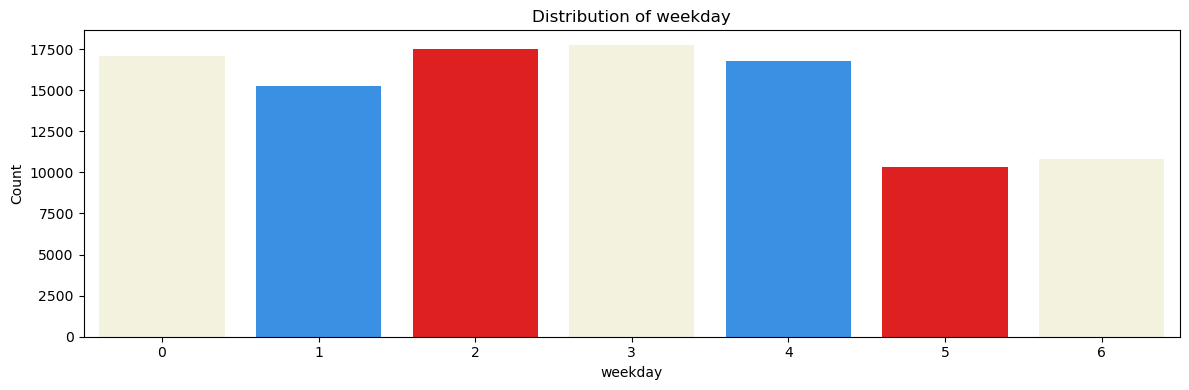

In [5]:
# Строим графики распределения для дат
plt.figure(figsize=(12, 4))
sns.histplot(data_train['created_date'].dt.date,
            color='dodgerblue',
            bins = 100,
            kde=True,     
            edgecolor='white',  
            linewidth=0.5,      
            stat='density') 
plt.title('Distribution of created_date')
plt.xlabel('created_date')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Строим графики распределения для времени
for col in ["day", "hour", "weekday"]:
    plt.figure(figsize=(12, 4))
    sns.countplot(x=data_train[col], palette=['beige','dodgerblue', 'red'], 
                  legend=False, hue=data_train[col])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

Так как у нас есть даныные только за несколько месяцев, нельзя отследить по другим годам, соответствует ли распределение по датам ожидаемому, тем не менее распределения правдоподобны

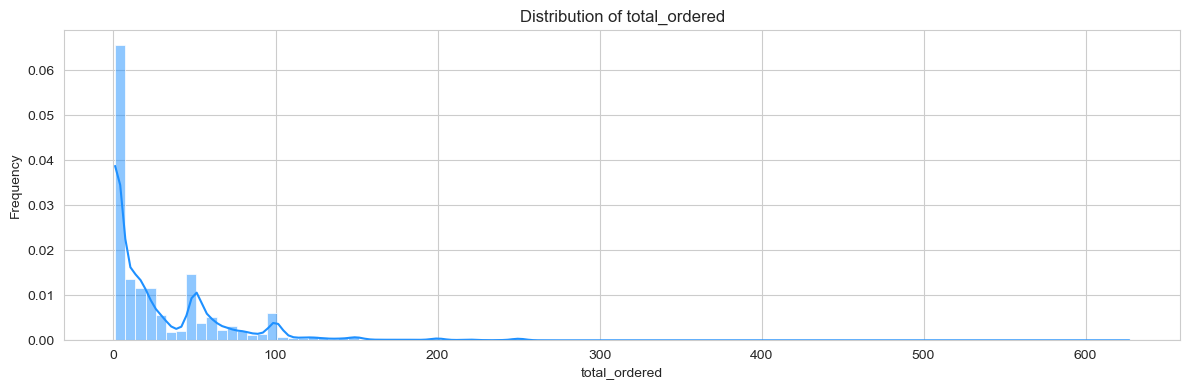

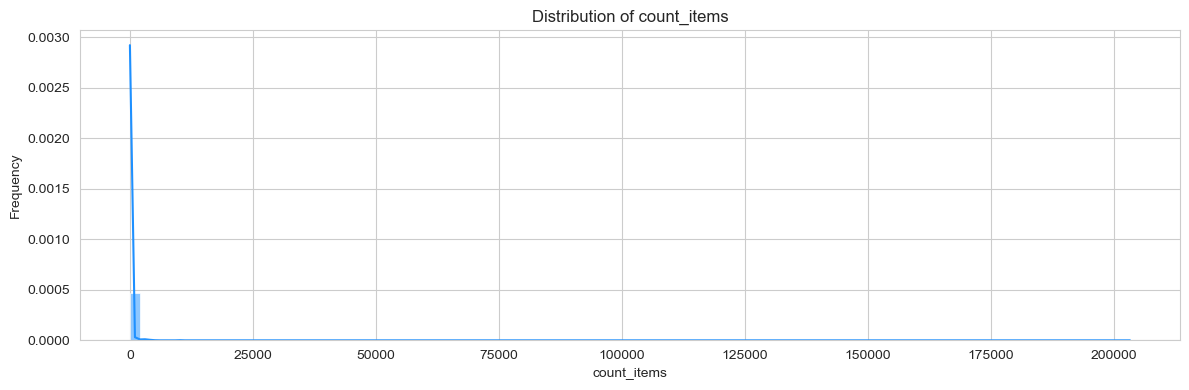

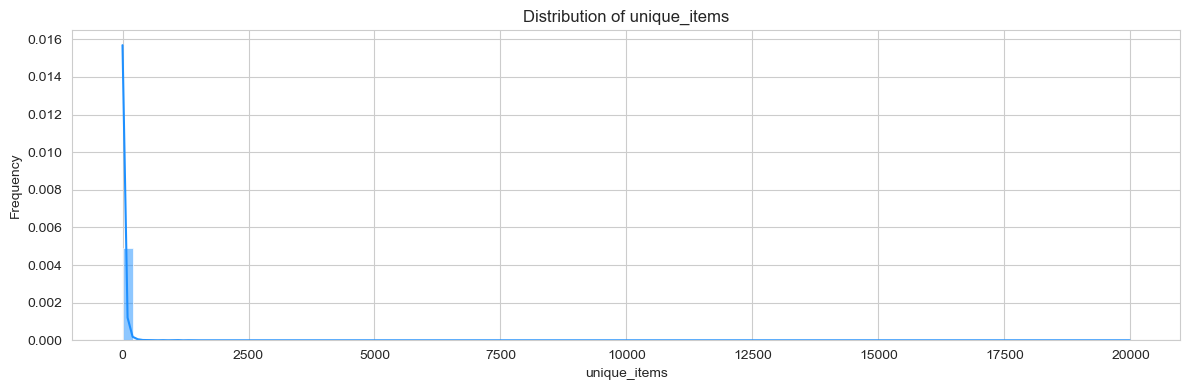

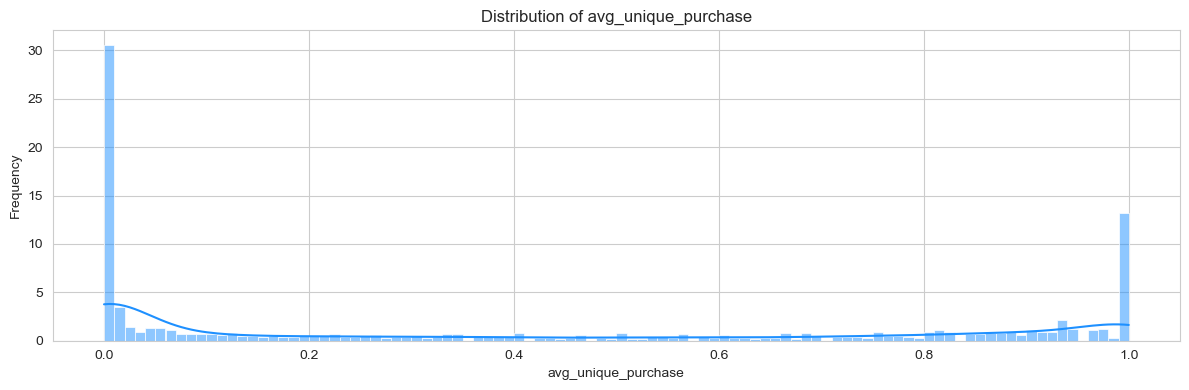

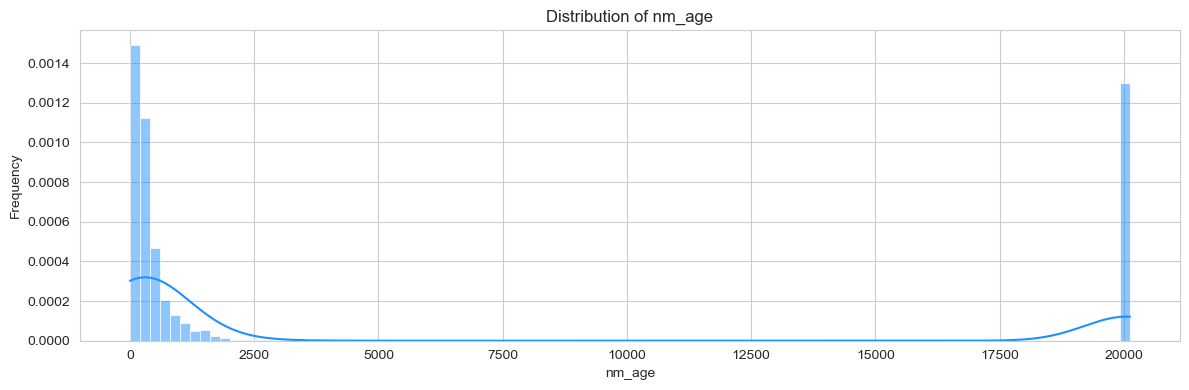

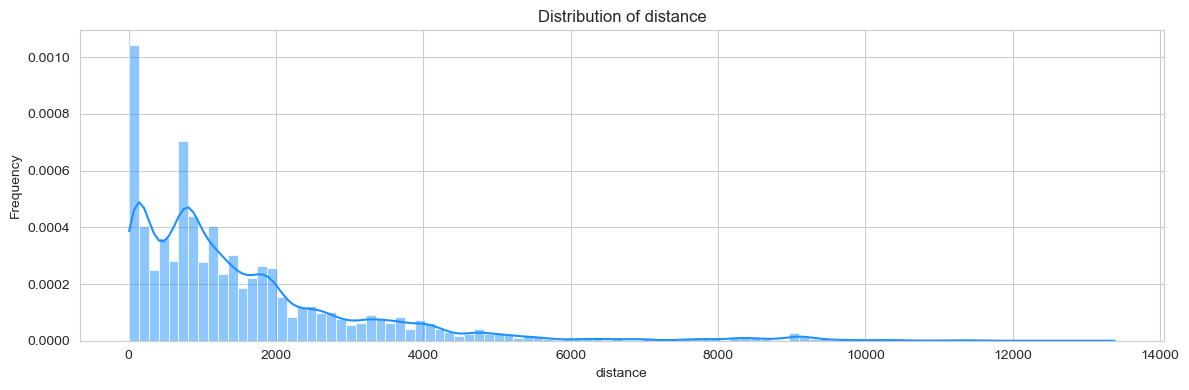

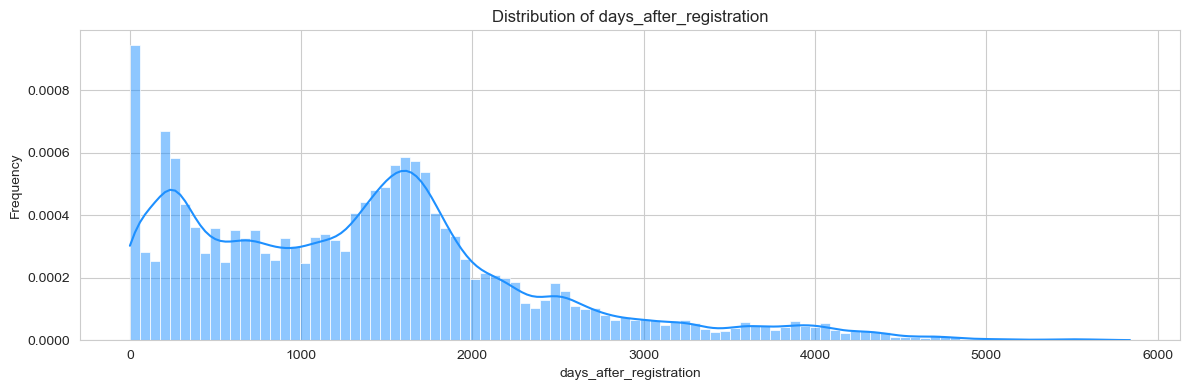

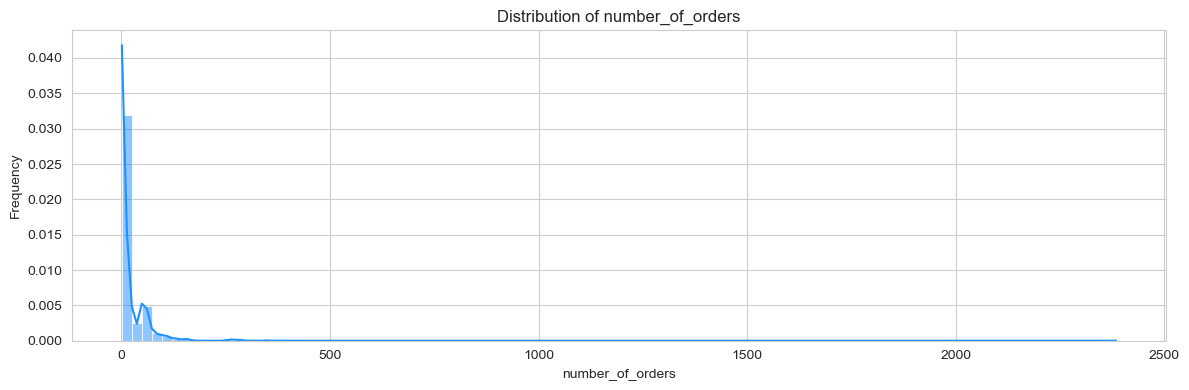

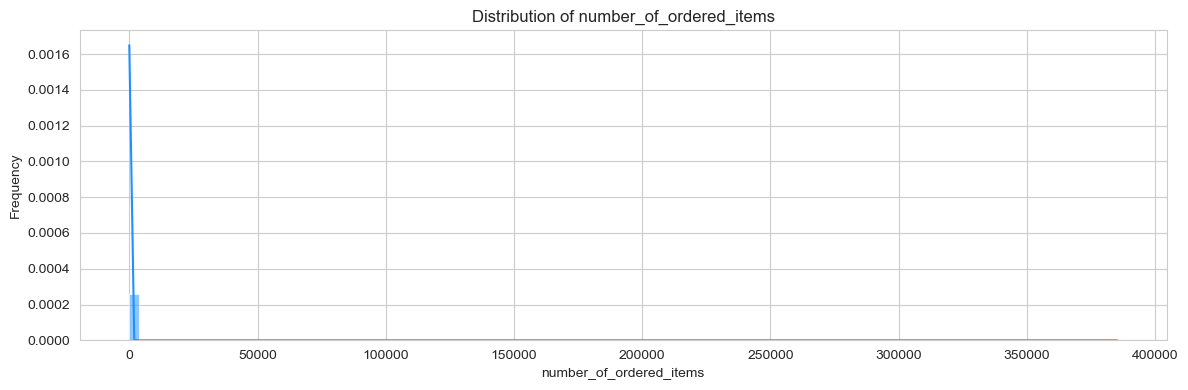

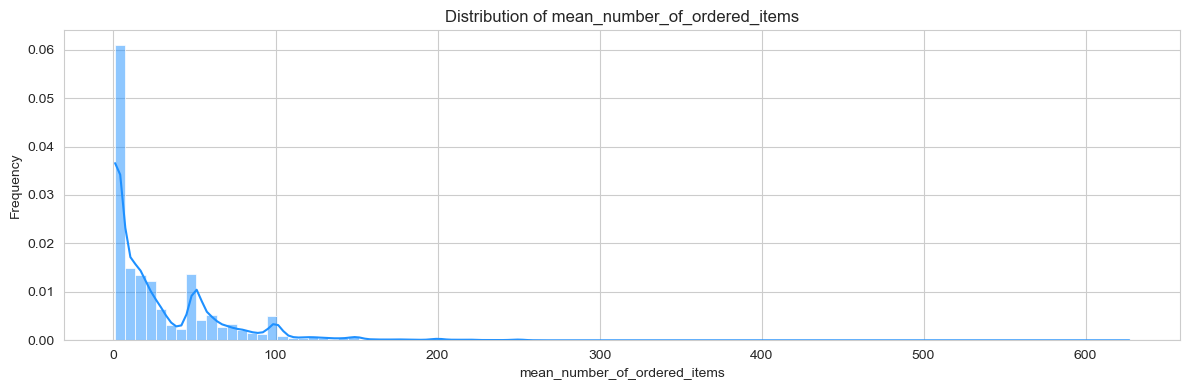

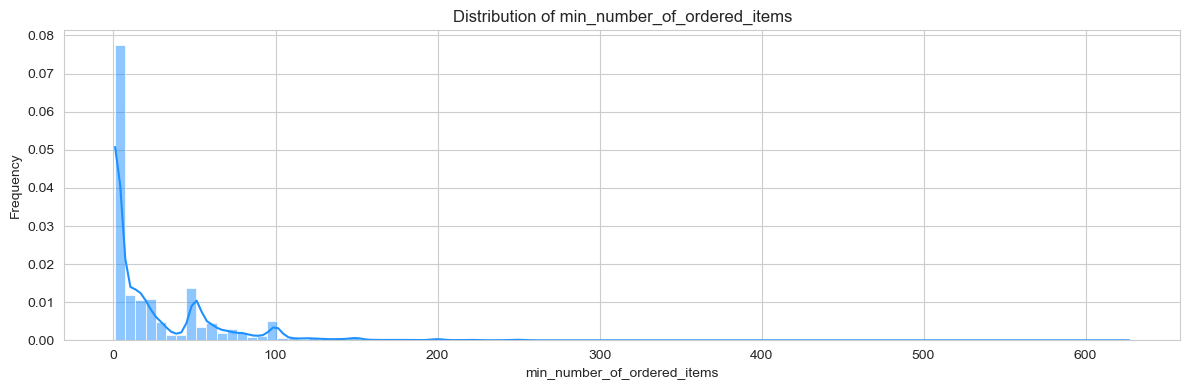

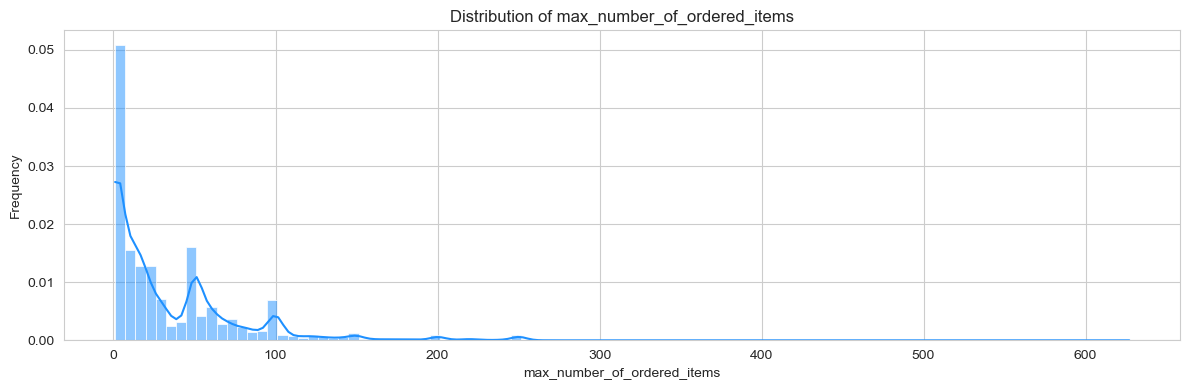

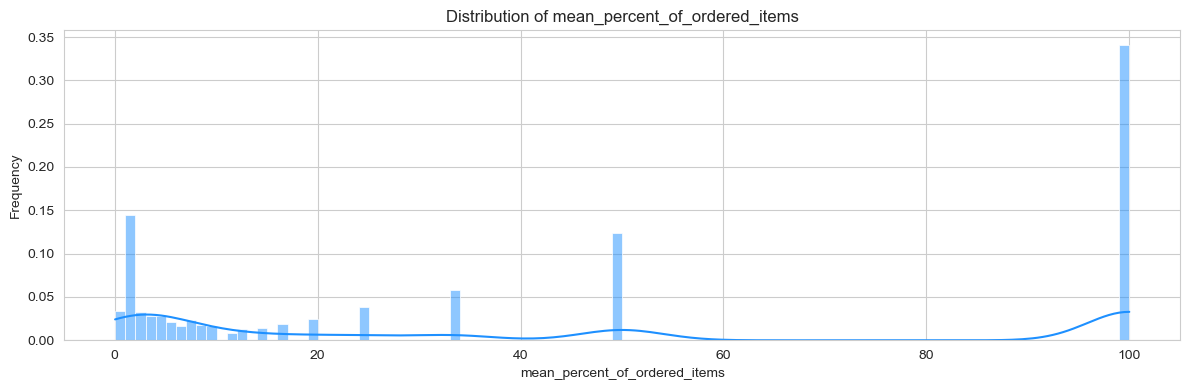

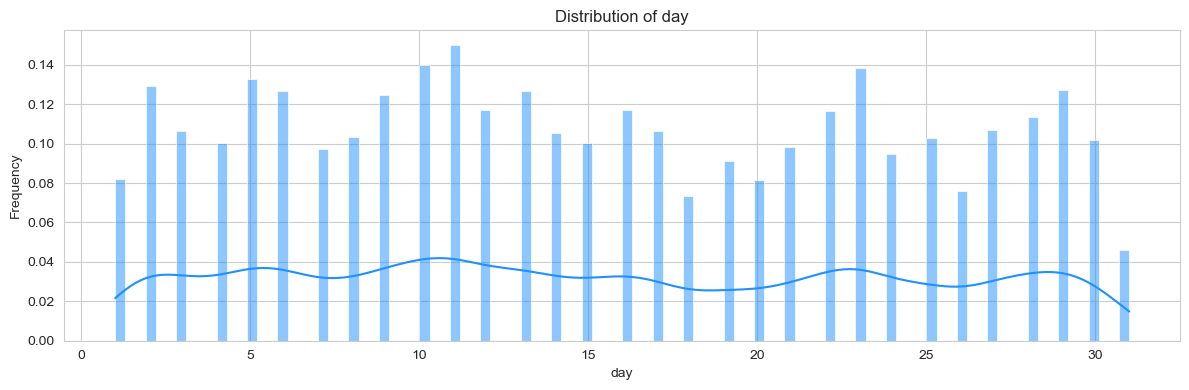

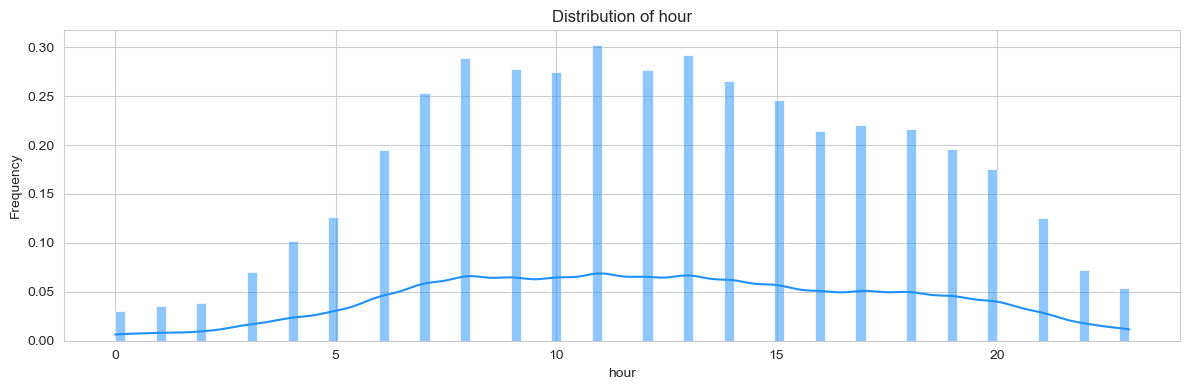

In [6]:
sns.set_style('whitegrid')

# Фильтруем категориальные и численные параметры и исключаем айди
cat_columns = ["is_paid", "is_courier", "service", "payment_type", "weekday"]

numerical_columns = [
    col for col in data_train.select_dtypes(include=['float64', 'int64', 'int32']).columns
    if ('id' not in col.lower()) and (col not in cat_columns) and (col != 'target')
]

# Строим для каждого гистограммы распределения
for i, col in enumerate(numerical_columns, 1):
    plt.figure(figsize=(12, 4))
    sns.histplot(
        data_train[col],
        color='dodgerblue',
        bins = 100,
        kde=True,     
        edgecolor='white',  
        linewidth=0.5,      
        stat='density' if data_train[col].nunique() > 20 else 'count'  
    )
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

Распределения соответствуют ожидаемым, при этом наблюдаем пики в `total_ordered`, `number_of_ordered_items`, `mean_percent_of_ordered_items` на 50, 100 и кратных им, а также пик в `days_after_registration` на нуле, эти пики могут свидетельствовать о фроде. Также на всех графиках касательно числа товаров мы видим, что у нас есть выбросы, которые стоит рассмотреть поподробнее, построив boxplot в зависимости от метки класса для каждого такого признака.

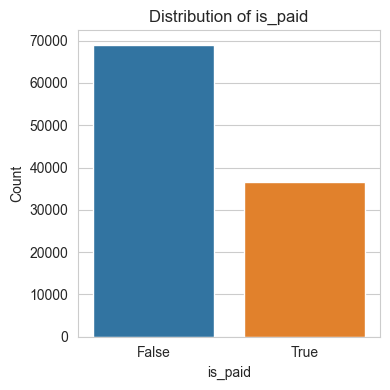

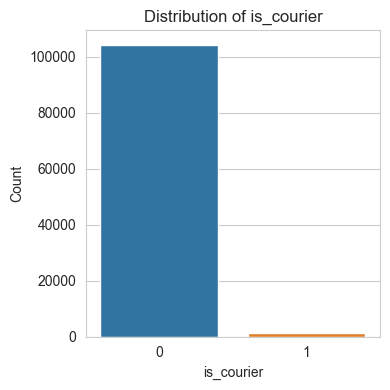

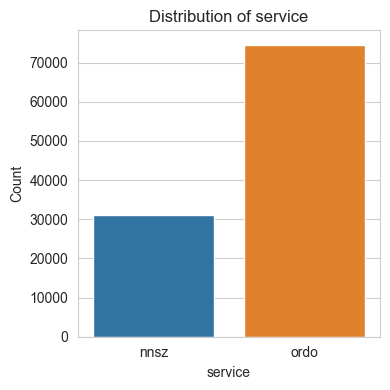

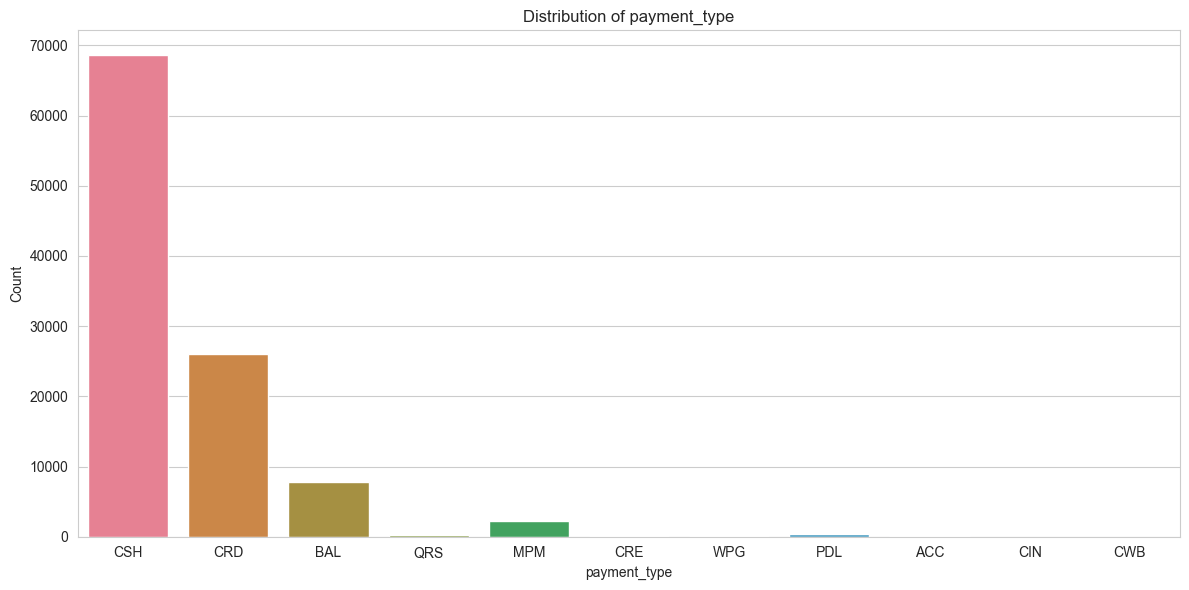

In [329]:
# Строим графики распределения категориальных переменных
for i, col in enumerate(cat_columns):
    plt.figure(figsize=(4, 4)) if len(data_train[col].unique()) <= 2 else plt.figure(figsize=(12, 6))
    sns.countplot(x=data_train[col], legend=False, hue=data_train[col])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

In [330]:
data_train.describe()

,user_id,nm_id,total_ordered,count_items,unique_items,avg_unique_purchase,is_courier,nm_age,distance,days_after_registration,number_of_orders,number_of_ordered_items,mean_number_of_ordered_items,min_number_of_ordered_items,max_number_of_ordered_items,mean_percent_of_ordered_items,target,day,hour,weekday
count,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000,105565.000000
mean,21169.816056,19504.235305,30.262322,256.541562,34.933851,0.403886,0.013243,5518.167887,1554.587572,1368.405589,20.504665,145.566902,30.249259,25.561417,36.207900,45.643031,0.126500,15.423985,12.295666,2.720608
std,12481.936785,13426.109359,40.532477,1023.116291,141.116667,0.406656,0.114314,8667.012801,1657.277528,995.599647,58.990701,2196.753376,38.607053,36.717645,44.659212,41.786504,0.332414,8.758490,5.193982,1.896111
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.041946,0.000000,1.000000,0.000000,0.000000
25%,9399.000000,6057.000000,1.000000,0.000000,0.000000,0.000000,0.000000,153.000000,472.000000,551.000000,1.000000,27.000000,1.649123,1.000000,3.000000,4.545455,0.000000,8.000000,8.000000,1.000000
50%,22640.000000,20774.000000,14.000000,22.000000,13.000000,0.250000,0.000000,363.000000,1066.000000,1344.000000,3.000000,56.000000,15.000000,10.000000,20.000000,33.333333,0.000000,15.000000,12.000000,3.000000
75%,34319.000000,33684.000000,50.000000,107.000000,39.000000,0.860000,0.000000,20004.000000,1995.000000,1843.000000,22.000000,94.000000,50.000000,50.000000,50.000000,100.000000,0.000000,23.000000,16.000000,4.000000
max,35433.000000,37224.000000,627.000000,203303.000000,19984.000000,1.000000,1.000000,20120.000000,13381.000000,5839.000000,2384.000000,385200.000000,627.000000,627.000000,627.000000,100.000000,1.000000,31.000000,23.000000,6.000000


Изучив отчёт, приходим к выводу, что необходимо обработать выбросы

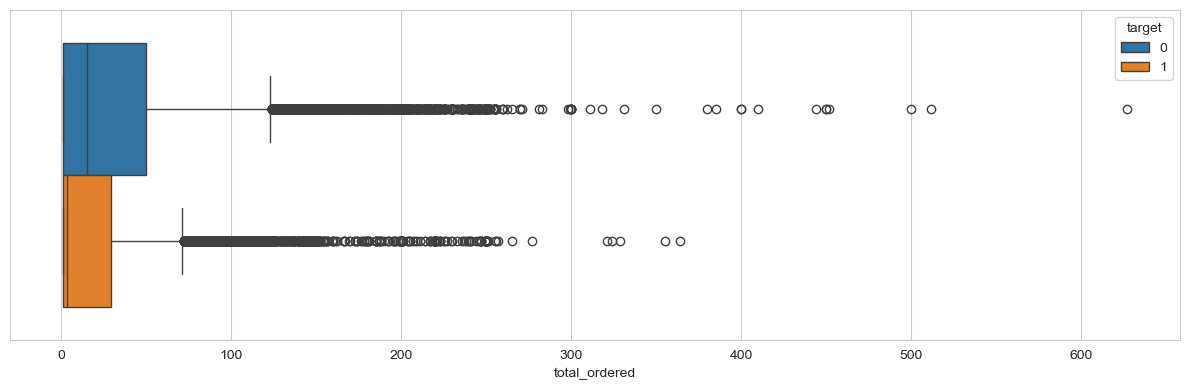

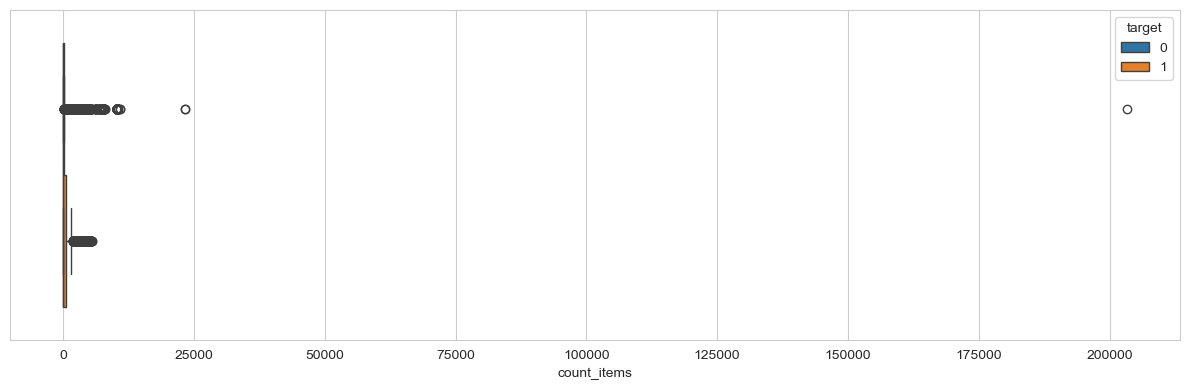

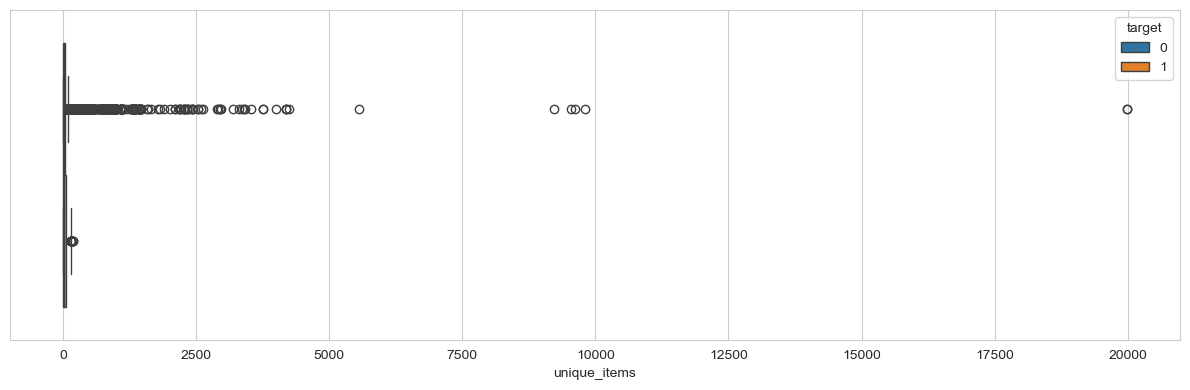

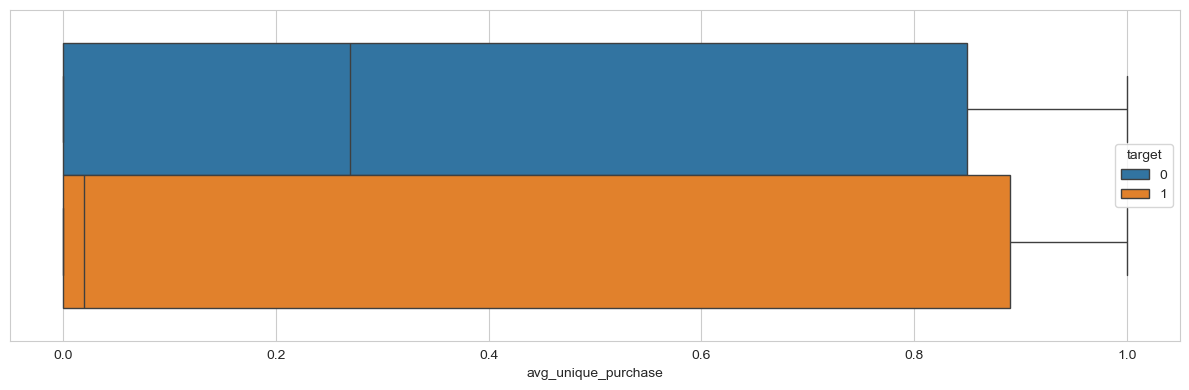

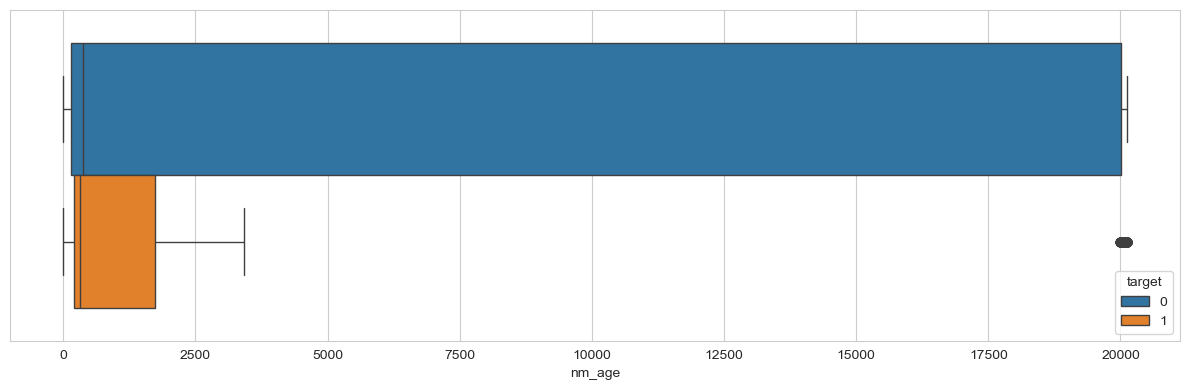

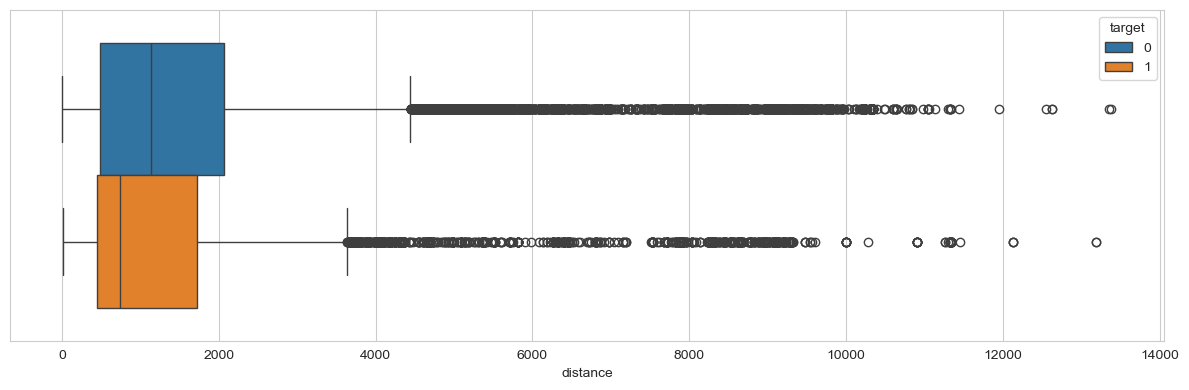

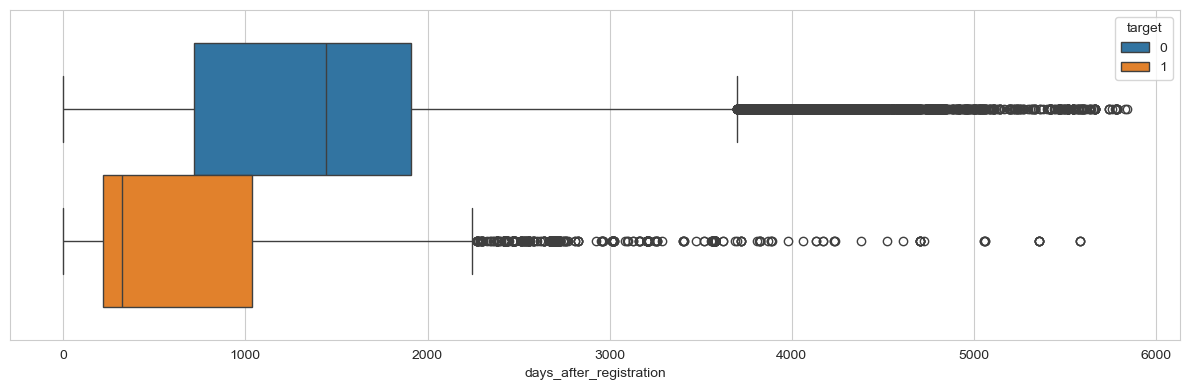

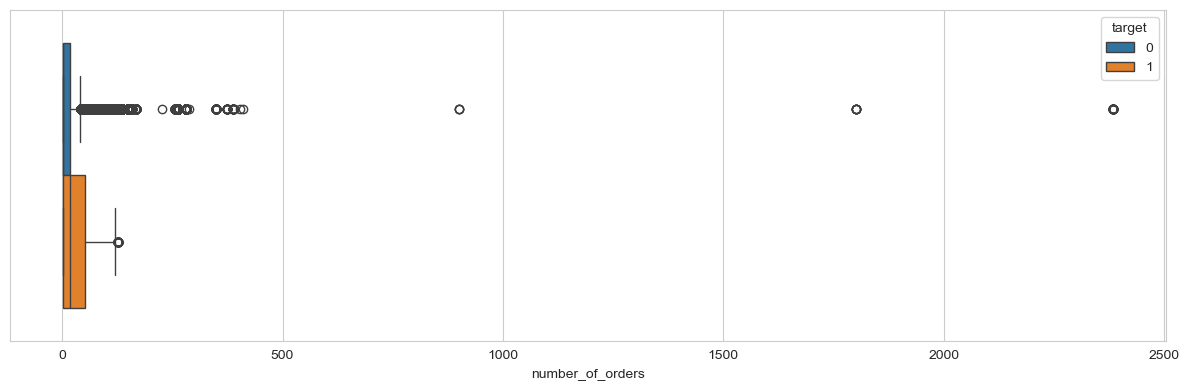

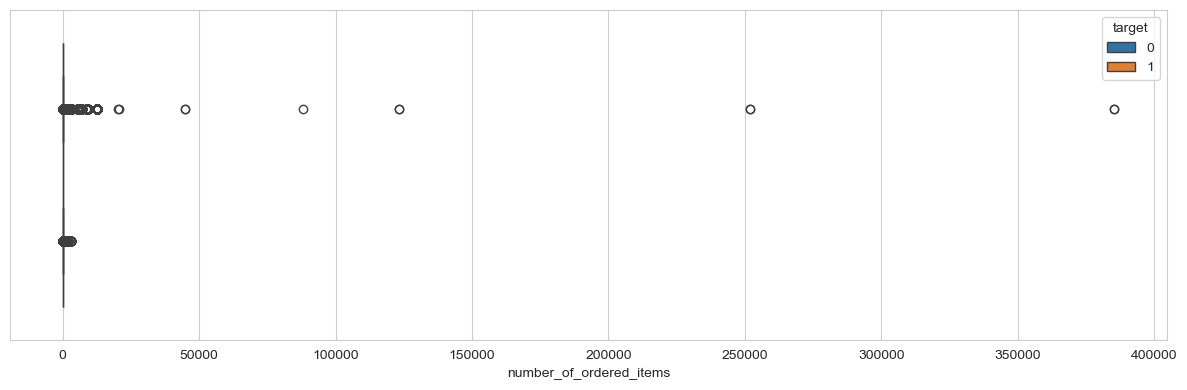

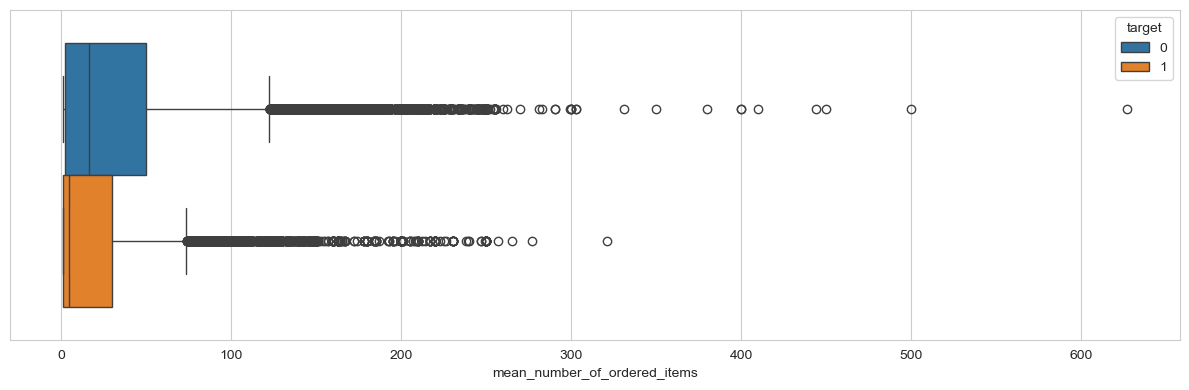

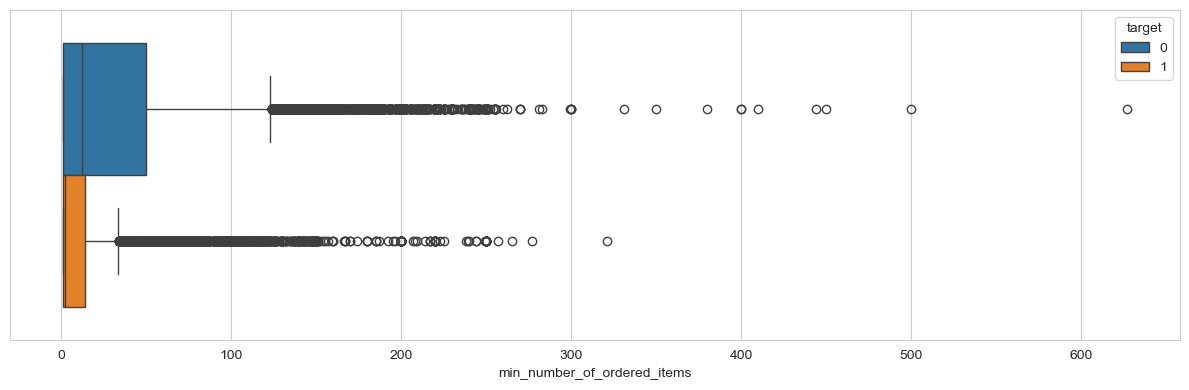

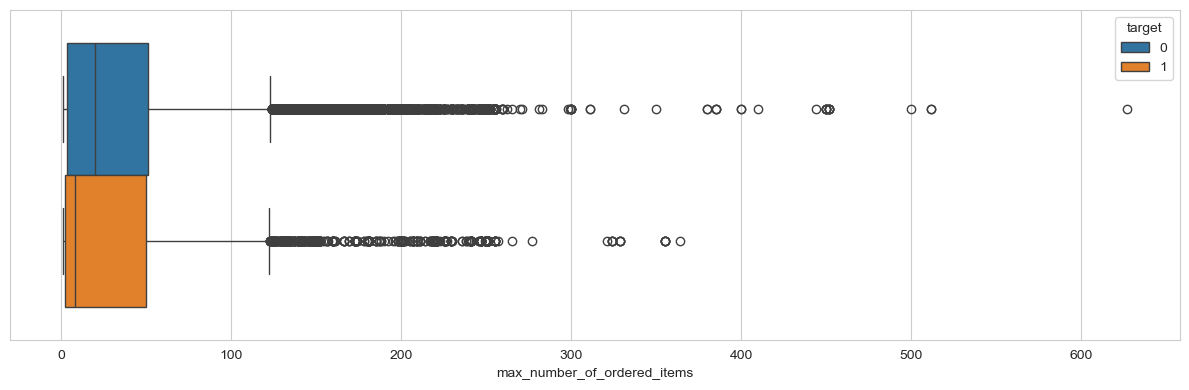

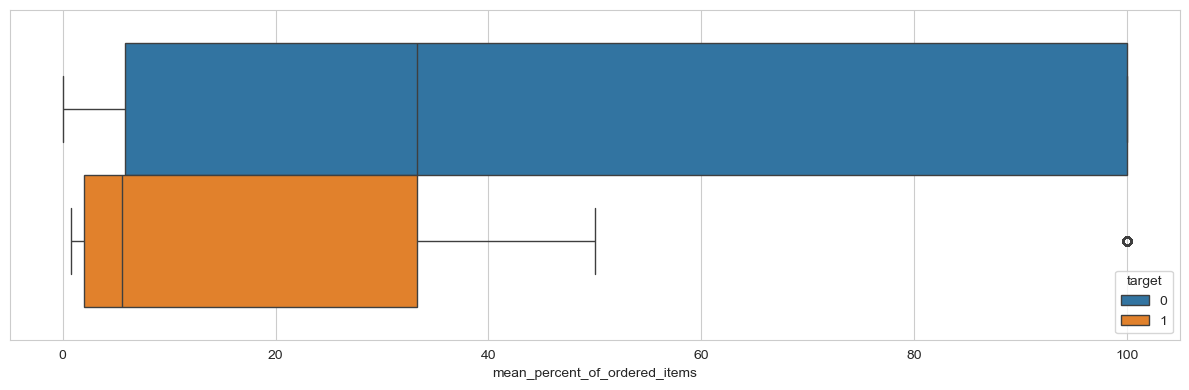

In [6]:
# Виcзуализация
cols_to_boxplot = list(data_train.select_dtypes(include=['int64', 'float64', 'int32']).columns) 
cols_to_boxplot = [x for x in cols_to_boxplot if x not in['is_courier','user_id', 'nm_id', 'target', 'weekday', 'day', 'hour']] 
for i, col in enumerate(cols_to_boxplot, 1):
    plt.figure(figsize=(12, 4))
    sns.boxplot(data = data_train, x= data_train[col], hue="target")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

Видим выбросы у обоих классов, следовательно, выбросы не являются маркерами мошенников.

## Удалим выбросы

In [7]:
# Определим значение 90% процентиля
def remove_outside_percentile(df, percentile=0.90, columns=None):
    """
    Удаляет строки, содержащие значения за пределами заданного процентиля
    
    Параметры:
    df - исходный датафрейм
    percentile - пороговый процентиль (по умолчанию 0.90)
    columns - список колонок для обработки (по умолчанию все числовые)
    
    Возвращает:
    Очищенный датафрейм
    """
    df_clean = df.copy()
    
    # Определяем колонки для обработки
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns
    
    # Вычисляем пороговые значения для каждой колонки
    thresholds = {col: df[col].quantile(percentile) for col in columns}
    
    # Создаем маску для фильтрации
    mask = pd.Series(True, index=df.index)
    for col, threshold in thresholds.items():
        mask &= (df[col] <= threshold) # типо логическое умножение, очень умно
    
    return df[mask]

In [8]:
data_train_cleaned = remove_outside_percentile(data_train, percentile=0.95)

In [9]:
data_train_cleaned.shape

(61109, 24)

## Импортируем библиотеки

In [10]:
# Импортируем библиотеки и методы для машинного обучения
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, make_scorer, precision_score, roc_auc_score

from catboost import Pool, CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

RANDOM_STATE=42

## Загружаем тестовый датасет

In [11]:
# Скачиваем тестовый датасет
data_test = pd.read_csv('./data/df_test.csv')
data_test = base_preprocess(data_test)
data_test.head()

,user_id,nm_id,created_date,service,total_ordered,payment_type,is_paid,count_items,unique_items,avg_unique_purchase,...,number_of_orders,number_of_ordered_items,mean_number_of_ordered_items,min_number_of_ordered_items,max_number_of_ordered_items,mean_percent_of_ordered_items,target,day,hour,weekday
0,35434,37225,2025-03-02 16:13:47+03:00,nnsz,854,CSH,False,0,0,0.00,...,1,854,854.0,854,854,100.0,1,2,16,6
1,35435,37226,2025-02-08 06:40:18+03:00,ordo,534,QRS,False,125,33,0.26,...,5,1062,212.4,88,534,20.0,0,8,6,5
2,35436,37227,2025-03-18 14:59:40+03:00,ordo,472,CRD,True,0,0,0.00,...,1,472,472.0,472,472,100.0,1,18,14,1
3,35437,338,2025-02-16 14:02:28+03:00,ordo,440,CSH,False,2212,9,0.00,...,1,440,440.0,440,440,100.0,0,16,14,6
4,35438,37228,2025-03-17 08:24:32+03:00,nnsz,400,CSH,False,0,0,0.00,...,1,400,400.0,400,400,100.0,0,17,8,0


## Scaling

In [12]:
# Отнормируем признаки для лог. регрессии 
from sklearn.preprocessing import MinMaxScaler

# Инициализация scaler
scaler = MinMaxScaler()
#Копирование df
data_train_scaled = data_train_cleaned.copy()
#Обучение на train и скалирование
data_train_scaled[numerical_columns] = scaler.fit_transform(data_train_cleaned[numerical_columns])
#Скадирование test'а
data_test_scaled = data_test.copy()
data_test_scaled[numerical_columns] = scaler.transform(data_test_scaled[numerical_columns])

In [13]:
from sklearn.preprocessing import OneHotEncoder

# Инициализация и обучение OHE
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore') 
train_encoded_data = encoder.fit_transform(data_train_scaled[cat_columns])

# Преобразуем в DataFrame
train_encoded_df = pd.DataFrame(
    train_encoded_data,
    columns=encoder.get_feature_names_out(cat_columns),
    index=data_train_scaled.index
)

# Объединяем с исходными данными
data_train_encoded = pd.concat([data_train_scaled.drop(cat_columns, axis=1), train_encoded_df], 
                               axis=1)


test_encoded_data = encoder.transform(data_test_scaled[cat_columns])

# Преобразуем в DataFrame
test_encoded_df = pd.DataFrame(
    test_encoded_data,
    columns=encoder.get_feature_names_out(cat_columns),
    index=data_test_scaled.index
)

# Объединяем с исходными данными
data_test_encoded = pd.concat([data_test_scaled.drop(cat_columns, axis=1), test_encoded_df], 
                               axis=1)


c:\Users\chudp\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Изучим корреляцию признаков
Посмотрим, какие признаки можно объединить, чтобы увеличить производительность и качество модели

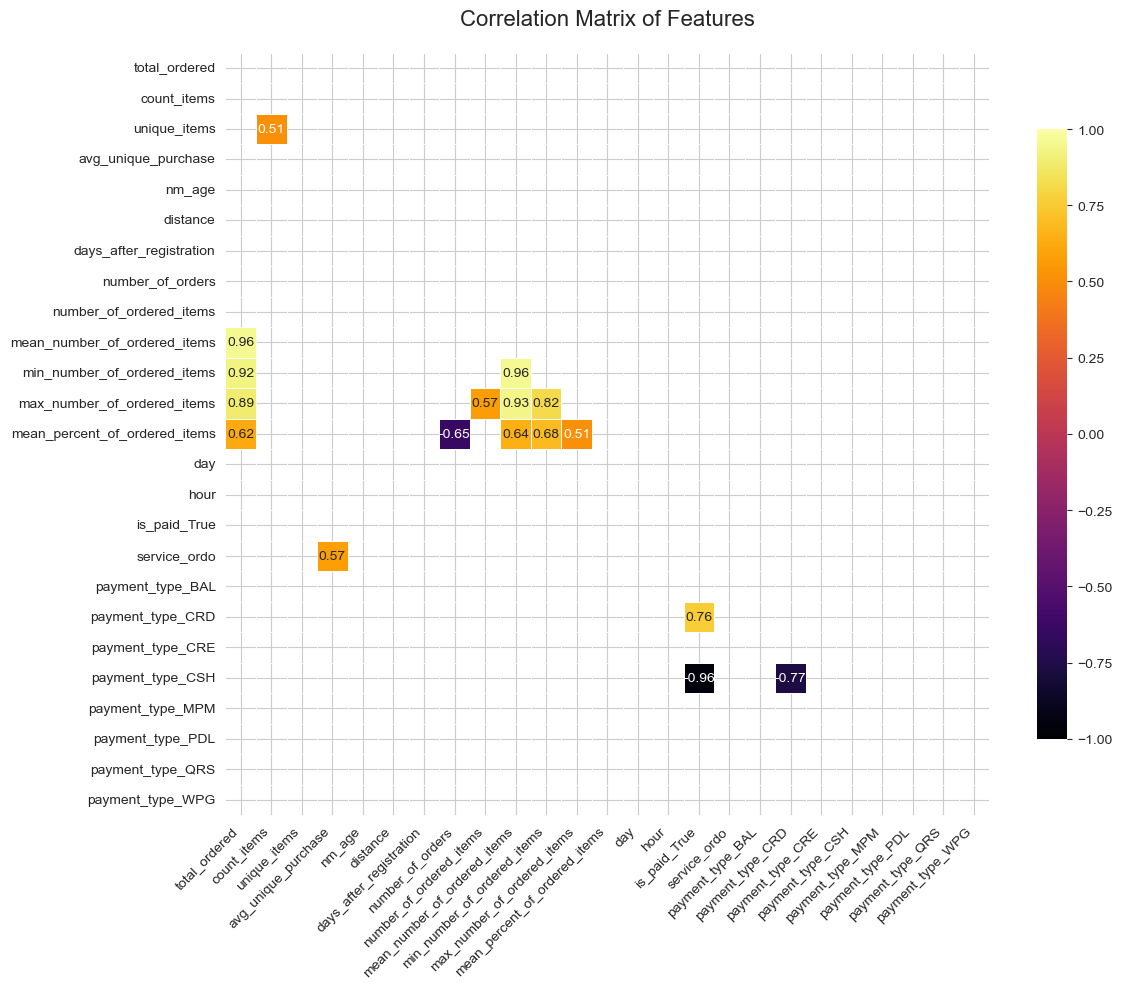

In [14]:
# Рассчитываем матрицу корреляций
columns_to_drop = (
    ['target', 'created_date', 'user_id', 'nm_id', 'payment_type_CIN', 'payment_type_CWB'] + 
    [f'weekday_{i}' for i in range(1, 7)] 
)
corr_matrix = data_train_encoded.drop(columns=columns_to_drop, 
                                      errors='ignore', 
                                      axis=1).corr()

# Создаем маску для верхнего треугольника (чтобы избежать дублирования)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) #блин, сложно, уже завтра пойму

# Выбираем только высококоррелированные пары (например, |corr| > 0.5)
high_corr = corr_matrix[abs(corr_matrix) > 0.5]

# Настраиваем размер графика
plt.figure(figsize=(12, 10))

# Строим heatmap
sns.heatmap(high_corr, 
            mask=mask,
            annot=True, 
            fmt=".2f", 
            cmap='inferno', 
            center=0,
            vmin=-1, 
            vmax=1,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})

# Настраиваем заголовок
plt.title('Correlation Matrix of Features', pad=20, fontsize=16)

# Поворачиваем подписи осей для лучшей читаемости
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Убираем лишние пробелы
plt.tight_layout()

plt.show()

У target'a ни с одним из признаков не было корреляции более 0.5

In [16]:
X = data_train_encoded.drop(columns=['target', 'created_date', 'user_id', 'nm_id', 'payment_type_CIN', 'payment_type_CWB'], errors='ignore', axis=1) #Добаляем payment_type_CIN payment_type_CWB, потому что этого типа оплаты нет в тестовом датасете
y = data_train_encoded['target']

In [17]:
X_ = data_train_encoded.drop(columns=['target', 'created_date', 'user_id', 'nm_id', 'payment_type_CIN', 'payment_type_CWB'], errors='ignore', axis=1) #Добаляем payment_type_CIN payment_type_CWB, потому что этого типа оплаты нет в тестовом датасете
y_ = data_train_encoded['target']

# Oversampling

Попытаемся решить проблему дисбаланса классов синтетическим созданием объектов минорного класса.

In [18]:
from imblearn.over_sampling import ADASYN

ada = ADASYN(random_state=RANDOM_STATE)
X_res, y_res = ada.fit_resample(X, y)

c:\Users\chudp\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.25, 
                                                    shuffle=True, stratify=y_res, 
                                                    random_state = RANDOM_STATE)

In [20]:
data_test.describe()

,user_id,nm_id,total_ordered,count_items,unique_items,avg_unique_purchase,is_courier,nm_age,distance,days_after_registration,number_of_orders,number_of_ordered_items,mean_number_of_ordered_items,min_number_of_ordered_items,max_number_of_ordered_items,mean_percent_of_ordered_items,target,day,hour,weekday
count,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000,14261.000000
mean,38636.763481,33109.423182,40.396887,143.269126,37.731716,0.535656,0.005960,5033.443587,1463.932403,1487.133791,20.258257,131.497090,40.345328,34.099642,49.474581,48.289676,0.126639,12.369399,12.092139,2.694832
std,1882.384713,13830.440286,48.431318,504.801439,82.273810,0.394806,0.076975,8392.091765,1649.064998,1017.676834,44.872361,382.191026,46.157652,43.792462,52.096839,41.543289,0.332580,7.437557,4.965116,2.010525
min,35434.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1.000000,12.000000,1.000000,1.000000,1.000000,0.081633,0.000000,1.000000,0.000000,0.000000
25%,36785.000000,37253.000000,2.000000,5.000000,3.000000,0.100000,0.000000,179.000000,335.000000,733.000000,1.000000,51.000000,3.062500,1.000000,9.000000,5.555556,0.000000,6.000000,8.000000,1.000000
50%,39044.000000,39377.000000,22.000000,32.000000,18.000000,0.600000,0.000000,391.000000,1035.000000,1493.000000,2.000000,66.000000,25.500000,15.000000,44.000000,50.000000,0.000000,12.000000,12.000000,2.000000
75%,40696.000000,41539.000000,60.000000,96.000000,44.000000,0.940000,0.000000,1675.000000,1896.000000,1976.000000,18.000000,103.000000,59.000000,54.000000,68.000000,100.000000,0.000000,18.000000,16.000000,4.000000
max,40848.000000,42191.000000,854.000000,18842.000000,2240.000000,1.000000,1.000000,20170.000000,12739.000000,5878.000000,1225.000000,14700.000000,854.000000,854.000000,854.000000,100.000000,1.000000,28.000000,23.000000,6.000000


# Random Forest

Будем использовать RandomSearchCV, чтобы повысить скорость подбора гиперпараметров.

In [21]:
from sklearn.ensemble import RandomForestClassifier

params = {
    # 'max_depth': list(range(7, 15)),
    # 'n_estimators': list(range(20, 60, 10))
    'max_depth': list(range(10, 12)),
    'n_estimators': list(range(50, 60, 10))
}

clf_rf = RandomForestClassifier(class_weight="balanced")

# Создаем вручную метрику, оценивающую precision для миноритарного класса
precision_minority = make_scorer(precision_score, pos_label=1)  

# Используем рандомизированный поиск лучших гиперпараметров с кросс-валидацией
grid_search_cv_clf_rf = RandomizedSearchCV(clf_rf, params, cv=5,
                                    scoring=precision_minority,
                                    # n_jobs=-1,  # Используем все ядра процессора
                                    verbose=1,
                                    refit=True  # Переобучит модель на лучших параметрах
)

grid_search_cv_clf_rf.fit(X_train, y_train)

# Результаты
print(f"Лучший параметр глубина дерева: {grid_search_cv_clf_rf.best_params_}")
print(f"Лучшее F1 на кросс-валидации: {grid_search_cv_clf_rf.best_score_:.4f}")

# Качество на тестовой выборке (если нужно)
y_pred_cat = grid_search_cv_clf_rf.predict(X_test)
f1_score_rf = f1_score(y_test, y_pred_cat)
print(f"F1 на тестовой выборке: {f1_score_rf}")

c:\Users\chudp\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Лучший параметр глубина дерева: {'n_estimators': 50, 'max_depth': 11}
Лучшее F1 на кросс-валидации: 0.8906
F1 на тестовой выборке: 0.9276470789087309


In [22]:
print(classification_report(y_pred_cat, y_test))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92     12737
           1       0.97      0.89      0.93     15256

    accuracy                           0.92     27993
   macro avg       0.92      0.93      0.92     27993
weighted avg       0.93      0.92      0.92     27993



In [23]:
y_pred_test =  grid_search_cv_clf_rf.predict(X_)
print(classification_report(y_, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     55845
           1       0.46      0.96      0.62      5264

    accuracy                           0.90     61109
   macro avg       0.73      0.93      0.78     61109
weighted avg       0.95      0.90      0.91     61109



Посмотрим, какие фичи дали самый большой прирост к IG (information gain) (clever words, nothing extra)

C:\Users\chudp\AppData\Local\Temp\ipykernel_24260\299363086.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=features_df, palette='cool')


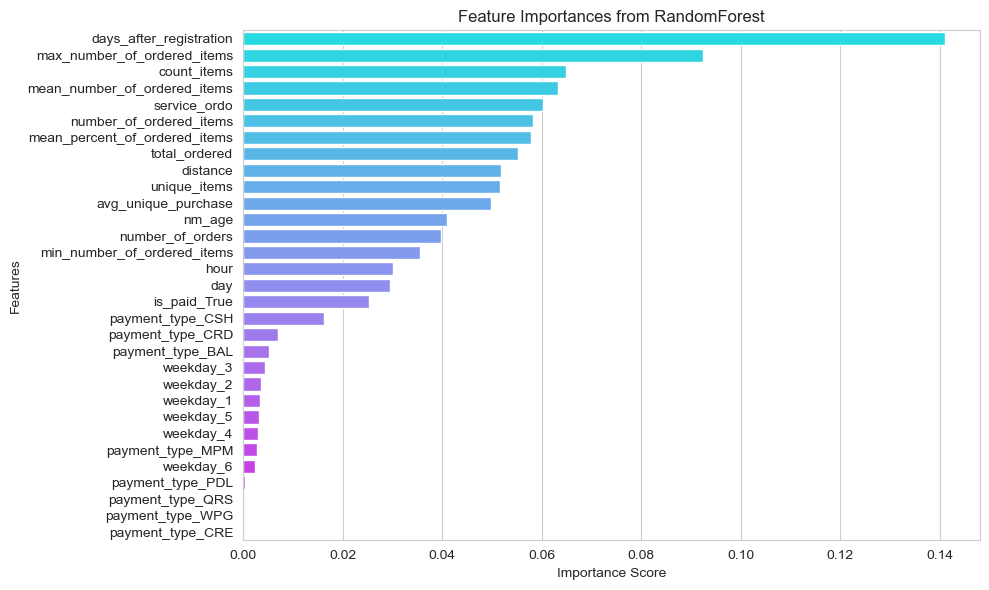

In [24]:
# Получаем важность фичей (предполагаем, что это RandomForest)
feature_importances = grid_search_cv_clf_rf.best_estimator_.feature_importances_

# Создаем DataFrame для удобства
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Сортируем по важности
features_df = features_df.sort_values('Importance', ascending=False)

# Выводим список фичей с их важностью
# print("Feature Importances:")
# print(features_df.to_string())

# Строим горизонтальный барплот
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df, palette='cool')
plt.title('Feature Importances from RandomForest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

График соответствует действительности: стоковые покупки делают с временных аккаунтов и один заказ содержит большое количество товаров.

# Catboost

Выбираем catbost как модель, которая лучше всего работает с категориальными переменными.

In [25]:
params = {
    'max_depth': list(range(10, 12)),
    'n_estimators': list(range(50, 60, 10))
}

cbc = CatBoostClassifier(random_state=RANDOM_STATE,
    class_weights=[1, 10], 
    eval_metric='Precision',
    early_stopping_rounds=50,
    verbose=0
)

grid_search_cv_clf_cat = RandomizedSearchCV(cbc, params, cv=5,
                                            scoring=precision_minority,
                                            # n_jobs=-1,  # Используем все ядра процессора
                                            verbose=0,
                                            refit=True  # Переобучит модель на лучших параметрах
)

grid_search_cv_clf_cat.fit(X_train, y_train, verbose=False)

# Результаты
print(f"Лучший параметр глубина дерева: {grid_search_cv_clf_cat.best_params_}")
print(f"Лучшее F1 на кросс-валидации: {grid_search_cv_clf_cat.best_score_:.4f}")
results_df = pd.DataFrame(grid_search_cv_clf_cat.cv_results_)

# Выводим средние значения F1-score для каждой комбинации параметров
print(results_df[['params', 'mean_test_score', 'std_test_score']])

# Качество на тестовой выборке (если нужно)
y_pred = grid_search_cv_clf_cat.predict(X_test)

f1_score_cat = f1_score(y_test, y_pred_cat)
print(f"F1 на тестовой выборке: {f1_score_cat:.4f}")

c:\Users\chudp\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучший параметр глубина дерева: {'n_estimators': 50, 'max_depth': 11}
Лучшее F1 на кросс-валидации: 0.9048
                                  params  mean_test_score  std_test_score
0  {'n_estimators': 50, 'max_depth': 10}         0.886185        0.004739
1  {'n_estimators': 50, 'max_depth': 11}         0.904777        0.002545
F1 на тестовой выборке: 0.9276


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     13962
           1       0.91      1.00      0.95     14031

    accuracy                           0.95     27993
   macro avg       0.95      0.95      0.95     27993
weighted avg       0.95      0.95      0.95     27993



In [27]:
y_pred_test = grid_search_cv_clf_cat.predict(X_)

In [28]:
print(classification_report(y_, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     55845
           1       0.56      0.99      0.71      5264

    accuracy                           0.93     61109
   macro avg       0.78      0.96      0.84     61109
weighted avg       0.96      0.93      0.94     61109



## Создаём файл с моделькой

Получили метрики, удовлетворяющие нашу команду. Сохраняем модель с лучшими параметрами. 

In [29]:
# import pickle
# # Сохранение модели в формате pickle
# best_model = grid_search_cv_clf_cat.best_estimator_
# with open('model.pkl', 'wb') as f:
#     pickle.dump(best_model, f)
grid_search_cv_clf_cat.best_estimator_.save_model('best_model.cbm')